In [1]:
import glob
import os
import json
from pathlib import Path
from shutil import copyfile
from collections import defaultdict

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.inception_v3 import InceptionV3

# imports
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten,
                                     MaxPooling2D, Conv2D, Lambda,
                                     Concatenate)
import tensorflow_hub as hub

In [2]:
primary_path = '../webvision-2020-public/classification/data/'

# Some Data Munging

**Skip this section if already done**

Start by building an directory structure for the validation data

In [ ]:
with open(primary_path + 'meta/train.txt', 'r') as f:
    training_files = f.readlines()

Build the mapping between synsets and class labels first.

In [ ]:
training_files[:10]

In [ ]:
synsets = list()
labels = list()

for line in training_files:
    line = line.strip()
    _, label = line.split(' ')
    synset, _ = line.split('/')
    if synset not in synsets:
        synsets.append(synset)
        labels.append(label)

# create a label mapping
mapping = dict()
for label, synset in zip(labels, synsets):
    mapping[label] = synset

Check

In [ ]:
len(labels)

In [ ]:
labels[:10]

In [ ]:
len(synsets)

In [ ]:
synsets[:10]

Use the mapping and the validation image label list in data/val.txt to create a validation image directory.

In [ ]:
# create a folder for validation data
os.mkdir(primary_path + 'validation')
# create a set of validation folders for generation
for synset in synsets:
    os.mkdir(primary_path + 'validation/' + synset)

In [ ]:
# read the validation image list and image labels
with open(primary_path + 'meta/val.txt', 'r') as f:
    val_files = f.readlines()

In [ ]:
val_files[:10]

In [ ]:
# copy the images and we're done
for line in val_files:
    line = line.strip()
    file_name, label = line.split(' ')
    new_path = primary_path + 'validation/' + mapping[label] + '/' + file_name
    copyfile(primary_path + 'val/' + file_name, new_path)

## Other Things

ID to synset mapping

In [ ]:
with open(primary_path + 'meta/train.txt', 'r') as f:
    training_files = f.readlines()

In [ ]:
mapping = dict()

for line in training_files:
    synset, other = line.split('/')[0]
    ID = other.split('.')[0]
    mapping[]

## Sort Meta Files into Training Folders

In [3]:
# get a list of all query files
files = glob.glob(primary_path + 'google/*') + glob.glob(primary_path + 'flickr/*')

In [4]:
# read in the id to synset mapping
id_synset_mapping = defaultdict(list)

with open(primary_path + 'meta/train.txt') as f:
    for line in f:
        synset, id_ = line.split(' ')[0].split('/')
        id_ = id_.split('.')[0]
        id_synset_mapping[id_] += [synset]

In [5]:
for file in files:
    with open(file, 'r') as f:
        # read the query files
        lines = json.load(f)
        # distribute each json object in a pair file
        for json_item in lines:
            for synset in id_synset_mapping[json_item['id']]:
                with open(primary_path + 'train/' + synset + '/' + json_item['id'], 'w') as outfile:
                    json.dump(json_item, outfile)

### Data Generation

In [94]:
class ImageMetaDataGenerator(Sequence):
    """Keras-like data generator for image and metadata
    """
    
    def __init__(self,
                 path,
                 batch_size,
                 target_size,
                 scaling = (1. / 255),
                 sample_frac = None) -> None:
        """Constructor
        
        :param path: path to data tree
        :param batch_size: size of batches used in training
        :param target_size: image size
        :param scaling: image scaling value
        :param sample_frac: per class sampling
        """
        self.path = path
        self.batch_size = batch_size
        self.target_size = target_size
        self.scaling = scaling
        self.sample_frac = sample_frac
        
        self.files = list()
        self.json_to_image_mapping = dict()
        self.label_mapping = dict()
        self.classes = list()

        # create a label maker
        classes = set(glob.glob(self.path + '*'))
        for i, label in enumerate(classes):
            label = label.split('/')[-1]
            self.classes.append(label)
            self.label_mapping[label] = i
        
        # get the file pathes
        # sample on a per class basis

        for class_path in classes:
            class_files = glob.glob(class_path + '/*.*')
            if self.sample_frac is not None:
                class_files = np.random.choice(class_files,
                                               np.floor(len(class_files) * self.sample_frac).astype(int),
                                               replace = False)
            self.files += list(class_files)

        print(f"Found {len(self.files)} instances belonging to {len(self.classes)} classes")
        
    def __len__(self):
        """Denotes the number of batches per epoch
        """
        return int(np.floor(len(self.files) / self.batch_size))
    
    def _load_image(self, path: str):
        """Load image convert to RGB and 
        """
        img = Image.open(path)
        img = img.resize(self.target_size).convert('RGB')
        img = np.array(img) * self.scaling
        return img
    
    def _load_metadata(self, path):
        with open(Path(path).with_suffix(''), 'r') as in_file:
            items = json.load(in_file)
            return items['description'], items['title']
    
    def __getitem__(self, index):
        """Generate one batch of data
        """
        labels = list()
        images = list()
        descriptions = list()
        titles = list()
        
        f_batch = self.files[index * self.batch_size:(index + 1) * self.batch_size]
        
        for f in f_batch:
            # get the text data
            desc, titl = self._load_metadata(f)
            descriptions.append(desc)
            titles.append(titl)
            # get the image
            images.append(
                self._load_image(f)
            )
 
            # get the label
            labels.append(
                self.label_mapping[
                    f.split('/')[-2]
                ]
            )

        img_reshape_size = [len(f_batch)] + list(self.target_size) + [3]
        
        return ([np.array(images).reshape(*img_reshape_size),
               np.array(descriptions),
               np.array(titles)],
               np.array(labels))
    
    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        np.random.shuffle(self.files)

In [84]:
classes = set(glob.glob(primary_path + '*'))

In [85]:
_list_img_files(list(classes)[1], 0.1)

[]

In [54]:
import time

In [95]:
start_time = time.time()
data = ImageMetaDataGenerator(primary_path + 'train/',
                              128,
                              (100,100),
                              sample_frac = .1)
end_time = time.time()

Found 1497365 instances belonging to 5000 classes


In [96]:
end_time - start_time

60.95217800140381

In [13]:
X[0].shape

(128, 100, 100, 3)

In [14]:
X[2]

array(['Air Staple Gun | eBay',
       'Arrow T50DCD cordless electric staple gun. Uses T50 staples',
       'Original Tacker® system - Roth',
       'Fastening tools / Staples for staple guns / Staples, 14 mm, for ...',
       'Used Commercial Industrial Specialty Sewing Machines 800-526-1184 ...',
       'SINGER 569 Bar Tacker | 42 Stitch Bar Tacking Machine', 'Footmac',
       'Filson Flagship Store Shop Visit - Seattle, WA - Carryology ...',
       'Worn Red Staple Gun On Black Stock Image - Image: 67012103',
       'Juki Mb-373 Zo32 Pleat Spot Tacker Drapery Curtain Industrial ...',
       'Air Nailer/Staple Gun - ALDI UK', 'Senco Staple Gun | eBay',
       'DSC_0082', 'Staple gun price, harga in Malaysia - lelong',
       'Free shipping Staple Gun Multifunction Nail Rapid Upholstery Hand ...',
       'speaker stand', 'Staple Guns - Fiswiki',
       'Buy TAKING Lock Stitch Sewing Machine, TK-6090-CXLS Online at Best ...',
       'Staple Gun Rapid Heavy Duty R34 - Upside Building',

In [7]:
len(data.classes)

5000

In [5]:
val_data = ImageMetaDataGenerator(primary_path + 'train/',
                                  128,
                                  (100,100),
                                  sample_frac = .1*.2)

Found 297493 instances belonging to 5000 classes


### Models

In [3]:
# load the USE
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# create USE layer
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))

In [14]:
embed_size = 512
# text part
input_text1 = Input(shape=(1,), dtype=tf.string, name = "input_text_1")
embedding1 = Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text1)
input_text2 = Input(shape=(1,), dtype=tf.string, name = "input_text_2")
embedding2 = Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text2)
# image part
input_image = Input(shape=(100,100,3), name = "input_image")
conv1 = Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(100,100,3))(input_image)
mpool1 = MaxPooling2D(2, 2)(conv1)
conv2 = Conv2D(32, kernel_size=(3, 3), activation='relu')(mpool1)
mpool2 = MaxPooling2D(2, 2)(conv2)
conv3 = Conv2D(64, kernel_size=(3, 3), activation='relu')(mpool2)
mpool3 = MaxPooling2D(2, 2)(conv3)
conv4 = Conv2D(64, kernel_size=(3, 3), activation='relu')(mpool3)
mpool4 = MaxPooling2D(2, 2)(conv4)
conv5 = Conv2D(64, kernel_size=(3, 3), activation='relu')(mpool4)
mpool5 = MaxPooling2D(2, 2)(conv5)
flat = Flatten()(mpool5)
# concat
x = Concatenate()([embedding1, embedding2, flat])
x = Dense(2048, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(len(data.classes),activation='softmax',name='output')(x)

comb_model = Model(inputs=[input_image, input_text1, input_text2], outputs=[output])
comb_model.summary()

comb_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_3), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_3), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 98, 98, 16)   448         input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 49, 49, 16)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 47, 47, 32)   4640        max_pooling2d_5[0][0]            
____________________________________________________________________________________________

In [15]:
image_text_hist = comb_model.fit(
                            data,
                            validation_data = val_data,
                            epochs=6
)

/home/stuart/anaconda3/envs/tf2/lib/python3.6/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 11698 steps, validate for 2324 steps
Epoch 1/6
   17/11698 [..............................] - ETA: 2:31:01 - loss: 8.5235 - accuracy: 0.0000e+00

/home/stuart/anaconda3/envs/tf2/lib/python3.6/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


11698/11698 [==============================] - 8869s 758ms/step - loss: 8.6118 - accuracy: 0.0120 - val_loss: 7.3963 - val_accuracy: 0.0434
Epoch 2/6
11698/11698 [==============================] - 8863s 758ms/step - loss: 7.1800 - accuracy: 0.0648 - val_loss: 5.9225 - val_accuracy: 0.1455
Epoch 3/6
11698/11698 [==============================] - 8872s 758ms/step - loss: 5.9221 - accuracy: 0.1499 - val_loss: 5.0006 - val_accuracy: 0.2461
Epoch 4/6
11698/11698 [==============================] - 8857s 757ms/step - loss: 5.2063 - accuracy: 0.2127 - val_loss: 4.5141 - val_accuracy: 0.3056
Epoch 5/6
11698/11698 [==============================] - 8940s 764ms/step - loss: 4.8224 - accuracy: 0.2516 - val_loss: 4.3228 - val_accuracy: 0.3270
Epoch 6/6
11698/11698 [==============================] - 9040s 773ms/step - loss: 4.5865 - accuracy: 0.2764 - val_loss: 4.2048 - val_accuracy: 0.3453


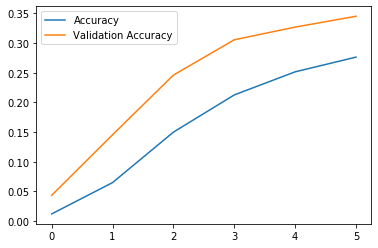

In [20]:
plt.plot(image_text_hist.history['accuracy'], label = 'Accuracy')
plt.plot(image_text_hist.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend();

## With Inception V3 Model

In [4]:
if not os.path.exists('./weights/'):
    os.mkdir('./weights/')

    !wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
        -O ./weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

local_weights_file = './weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [7]:
embed_size = 512
# text part
input_text1 = Input(shape=(1,), dtype=tf.string, name = "input_text_1")
embedding1 = Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text1)
input_text2 = Input(shape=(1,), dtype=tf.string, name = "input_text_2")
embedding2 = Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text2)

# image part
pre_trained_model = InceptionV3(input_shape = (100, 100, 3), 
                                include_top = False, 
                                weights = None)
# load the weights
pre_trained_model.load_weights(local_weights_file)

# lock the layers
for layer in pre_trained_model.layers:
    layer.trainable = True

# use mixed10 as the last layer from inception3
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output layer to 1 dimension
flat = Flatten()(last_output)

# combination
x = Concatenate()([embedding1, embedding2, flat])
#x = Dense(2048, activation='relu')(x)
x = Dropout(0.2)(x)

#output = Dense(len(data.classes),activation='softmax',name='output')(x)

output = Dense(5000,activation='softmax',name='output')(x)

comb_model = Model(inputs=[pre_trained_model.input, input_text1, input_text2], outputs=[output])
comb_model.summary()

comb_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

The following Variables were used a Lambda layer's call (lambda_4), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_4), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_5), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_5), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

last layer output shape:  (None, 1, 1, 2048)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 49, 49, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 49, 49, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 49, 49, 32)   0           batch_normalization_188[0][0]    
_______________________________________________

In [15]:
image_text_hist = comb_model.fit(
                            data,
                            validation_data = val_data,
                            epochs=6
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 11698 steps, validate for 2324 steps
Epoch 1/6
   22/11698 [..............................] - ETA: 2:41:51 - loss: 9.4186 - accuracy: 0.0000e+00

/home/stuart/anaconda3/envs/tf2/lib/python3.6/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


11698/11698 [==============================] - 8921s 763ms/step - loss: 8.9457 - accuracy: 0.0013 - val_loss: 8.5968 - val_accuracy: 0.0031
Epoch 2/6
11698/11698 [==============================] - 8972s 767ms/step - loss: 8.6651 - accuracy: 0.0029 - val_loss: 8.4896 - val_accuracy: 0.0015
Epoch 3/6
11698/11698 [==============================] - 8956s 766ms/step - loss: 8.6083 - accuracy: 0.0028 - val_loss: 8.4808 - val_accuracy: 0.0031
Epoch 4/6
11698/11698 [==============================] - 8961s 766ms/step - loss: 8.5825 - accuracy: 0.0032 - val_loss: 8.4713 - val_accuracy: 0.0031
Epoch 5/6
11698/11698 [==============================] - 9032s 772ms/step - loss: 8.5681 - accuracy: 0.0032 - val_loss: 8.4756 - val_accuracy: 0.0031
Epoch 6/6
11698/11698 [==============================] - 9131s 781ms/step - loss: 8.5655 - accuracy: 0.0034 - val_loss: 8.4796 - val_accuracy: 0.0031


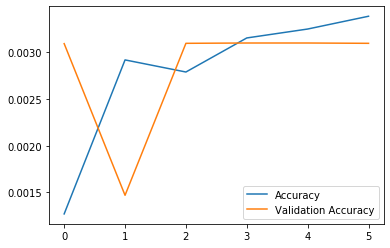

In [16]:
plt.plot(image_text_hist.history['accuracy'], label = 'Accuracy')
plt.plot(image_text_hist.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend();